# What impacts students' performance?

### About the data

### Get the data

Load the packages

In [37]:
packages <- c("RCurl","data.table","tidyverse","reshape2", "ggplot2","gridExtra")
sapply(packages, require, character.only=T)

Loading required package: RCurl

Attaching package: ‘RCurl’

The following object is masked from ‘package:tidyr’:

    complete



RCurl data.table  tidyverse   reshape2    ggplot2  gridExtra 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE

In [38]:
# What are the files?
path<- getwd()
path <- file.path(path, "Student")
list.files(path)

[1] "student-mat.csv" "student-merge.R" "student-por.csv" "student.txt"

In [39]:
# Reading files 
math <- fread(file.path(path,"student-mat.csv"), stringsAsFactors=T)
port <- fread(file.path(path,"student-por.csv"), stringsAsFactors=T)

### Manipulate the data

In [40]:
# Any missing values?
sum(is.na(data))

[1] 0

In [41]:
library(tidyverse)
# Adding a variable
math$average <- round(apply(select(math, G1, G2, G3), 1, mean), 2)
port$average <- round(apply(select(port, G1, G2, G3), 1, mean), 2)

In [42]:
math$subject<- rep("Math", nrow(math))
port$subject<- rep("Portugese", nrow(port))

In [43]:
# Combining two datasets
data <- rbind(math, port)
head(data)

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout,Dalc,Walc,health,absences,G1,G2,G3,average,subject
GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,1,1,3,6,5,6,6,5.67,Math
GP,F,17,U,GT3,T,1,1,at_home,other,...,3,1,1,3,4,5,5,6,5.33,Math
GP,F,15,U,LE3,T,1,1,at_home,other,...,2,2,3,3,10,7,8,10,8.33,Math
GP,F,15,U,GT3,T,4,2,health,services,...,2,1,1,5,2,15,14,15,14.67,Math
GP,F,16,U,GT3,T,3,3,other,other,...,2,1,2,5,4,6,10,10,8.67,Math
GP,M,16,U,LE3,T,4,3,services,other,...,2,1,2,5,10,15,15,15,15.00,Math


### Tidy variables
Support categories

In [44]:
data$support <- "0"
data[schoolsup=="yes"& famsup=="yes"]$support<- "both"
data[schoolsup=="yes"& famsup!="yes"]$support<- "school"
data[schoolsup!="yes"& famsup=="yes"]$support<- "family"
data[schoolsup!="yes"& famsup!="yes"]$support<- "none"
data$support <- as.factor(data$support)
data <- select(data, -c("schoolsup","famsup"))

In [45]:
# Split the data set to analyze
family<- select(data, c(5:10, 12, 22, 29:33))
personal<- select(data, -c(5:10, 12, 22))

#### Family set

In [46]:
head(family, 4)

famsize,Pstatus,Medu,Fedu,Mjob,Fjob,guardian,famrel,G1,G2,G3,average,subject
GT3,A,4,4,at_home,teacher,mother,4,5,6,6,5.67,Math
GT3,T,1,1,at_home,other,father,5,5,5,6,5.33,Math
LE3,T,1,1,at_home,other,mother,4,7,8,10,8.33,Math
GT3,T,4,2,health,services,mother,3,15,14,15,14.67,Math


#### Personal set

In [47]:
head(personal, 4)

school,sex,age,address,reason,traveltime,studytime,failures,paid,activities,...,Dalc,Walc,health,absences,G1,G2,G3,average,subject,support
GP,F,18,U,course,2,2,0,no,no,...,1,1,3,6,5,6,6,5.67,Math,school
GP,F,17,U,course,1,2,0,no,no,...,1,1,3,4,5,5,6,5.33,Math,family
GP,F,15,U,other,1,2,3,yes,no,...,2,3,3,10,7,8,10,8.33,Math,school
GP,F,15,U,home,1,3,0,yes,yes,...,1,1,5,2,15,14,15,14.67,Math,family


### Analysis

#### Is there a relationship between the three exams?

In [48]:
# create a helper function to graph
graph <- function(data, x, y){
    a <- enquo(x)
    b <- enquo(y)
    dt<- enquo(data)
    ggplot(data, aes(!!a, !!b))+ 
        geom_smooth(method=lm,se=T, color="black")+
        geom_jitter(alpha=0.5, color="blue")+
        labs(title= deparse(substitute(data)), subtitle=nrow(data))
}

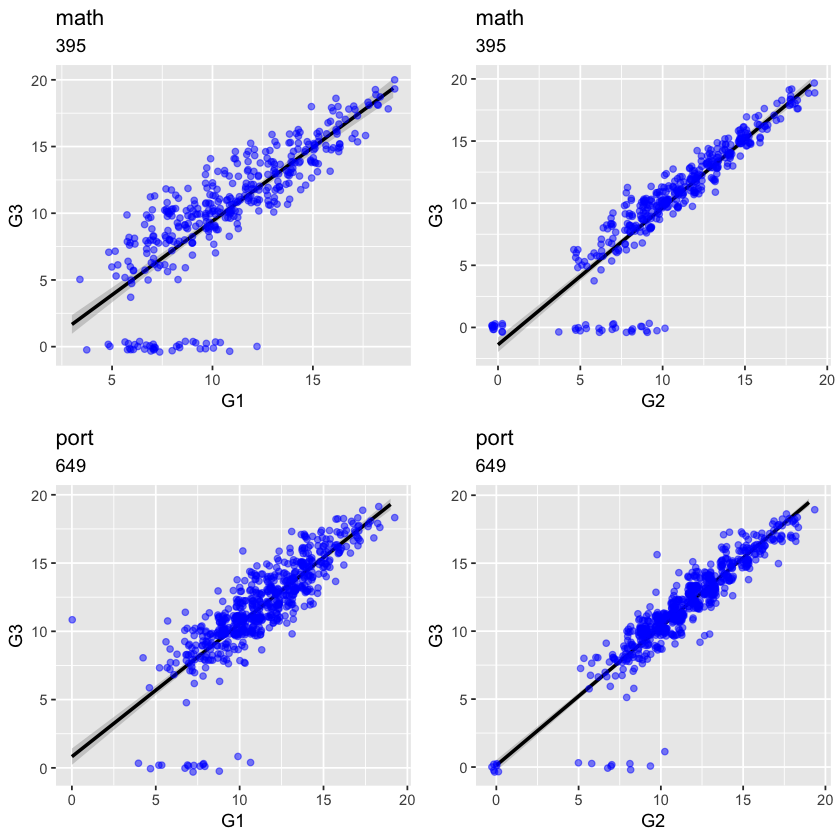

In [49]:
# Graph all the graphs
p1<- graph(math, G1, G3)
p2<- graph(math, G2, G3)
p3<- graph(port, G1, G3)
p4<- graph(port, G2, G3)
grid.arrange(p1, p2, p3, p4, ncol = 2, nrow = 2)

The first and second period grade both positively correlate with the final grade. In addition, the second period grade seems to be a slightly better indicator of the final grade.
Therefore, knowing what affects G1 and G2 can help us learn what impacts that final results.
In this part, we examine family-related factors.

### **1. FAMILY SIZE AND PARENTAL STATUS**

Firstly, consider the family dataset. Let's see if family size affects a student's grade

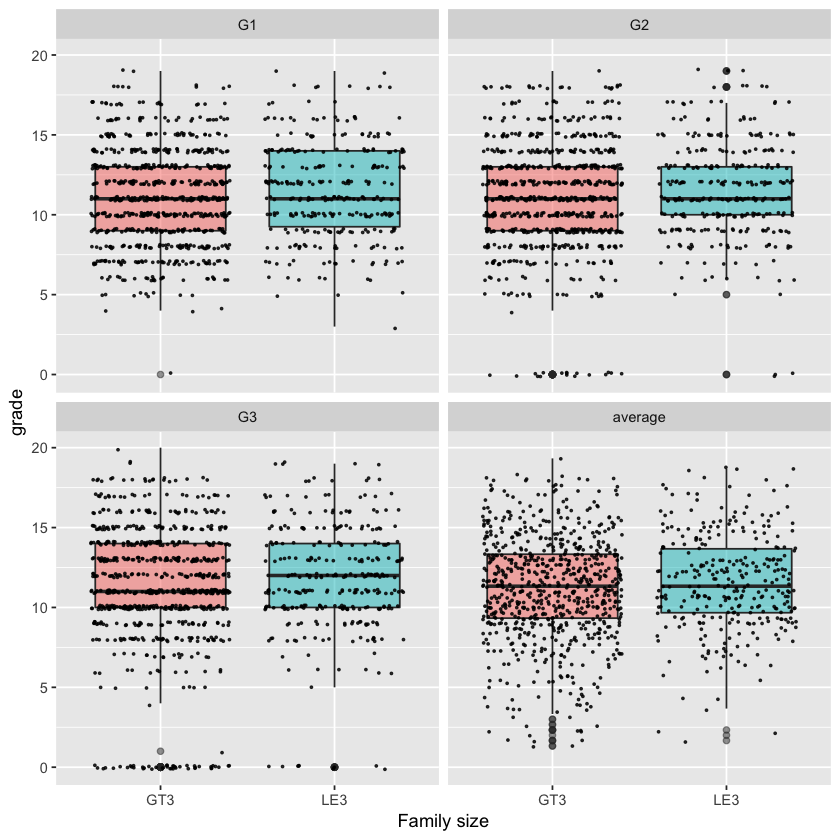

In [50]:
family %>%
    gather(key=test, value=grade, -c(1:8, 13)) %>%
    ggplot(aes(x=famsize, y=grade, fill=famsize))+
    geom_boxplot(alpha=0.5)+
    geom_jitter(size=0.4, alpha=0.8)+
    theme(legend.position="none")+
    facet_wrap(~test)+
    xlab("Family size")

#### Some quick observation shows that there is not much difference in the grade distribution fro students living in family with more than 3 people and less than 3 people

How about parental status?

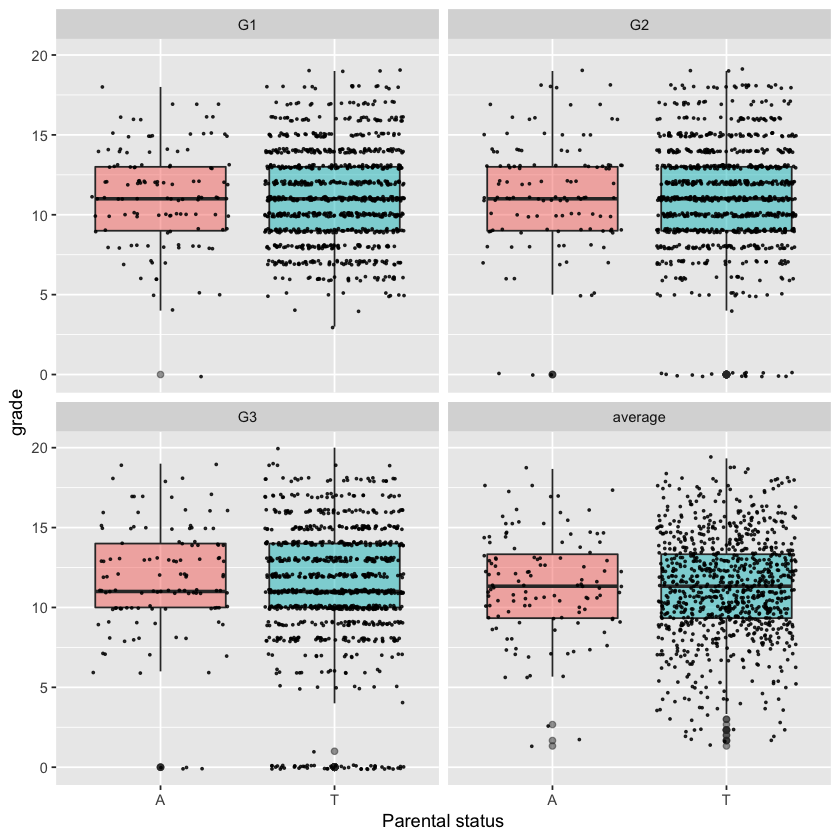

In [51]:
family %>%
    gather(key=test, value=grade, -c(1:8, 13)) %>%
    ggplot(aes(x=Pstatus, y=grade, fill=Pstatus))+
    geom_boxplot(alpha=0.5)+
    facet_wrap(~test)+ geom_jitter(size=0.4, alpha=0.8)+
    theme(
      legend.position="none",
    )+
    xlab("Parental status")

#### Interestingly, both parental status and family size do not seem to make a difference in the student's performance like what I expected. But due to the difference in the number of students in each category, I perform a t-test, which accounts for the category sizes, to make sure if there is no significance in the family status on the student's grade or not

In [55]:
t.test(average~famsize,data=family, var.equal=T, alternative="greater")$p.value

[1] 0.9772113

In [56]:
t.test(average~Pstatus,data=family, var.equal=T, alternative="greater")$p.value

[1] 0.3048344

#### The large p-value shows that there isn't much difference in the average grade between a child whose parents are apart and that with parents living together. The same conclusion can be drawn between students living in family with more than 3 people and students living with fewer than or equal to 3 people. Hence, parental status and family size don't impact the grade in a significant way.

Notice that there are a quite a few students with 0 mark in their final exam in family with parents living together, in comparison to students with separated parents. The same trend is observed in family of size greater than 3 as opposed to family with less than or equal to 3 members. We do a brief examination.

In [57]:
prop.test(x=c(50,4), n=c(923,121), correct=T)
prop.test(x=c(45,9), n=c(738,306), correct=T)


	2-sample test for equality of proportions with continuity correction

data:  c(50, 4) out of c(923, 121)
X-squared = 0.58943, df = 1, p-value = 0.4426
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.01860424  0.06083090
sample estimates:
    prop 1     prop 2 
0.05417118 0.03305785 



	2-sample test for equality of proportions with continuity correction

data:  c(45, 9) out of c(738, 306)
X-squared = 3.7737, df = 1, p-value = 0.05206
alternative hypothesis: two.sided
95 percent confidence interval:
 0.003631887 0.059495803
sample estimates:
    prop 1     prop 2 
0.06097561 0.02941176 


Regarding proportions, the proportion of students with 0 mark on the final exam whose parents live together does not differ significantly from that of students whose parents are separate. This is also true for both famsize categories.

Through the graphs above, we can also see that students have greater difficuty in the second period than in the first one, which by far makes sense as the level of difficulty would usually goes up towards the end of year.

Now that famzise and parental status don't contribute much to our finding, let's move on to the next elements.

### **2. MOTHER'S AND FATHER'S JOB**

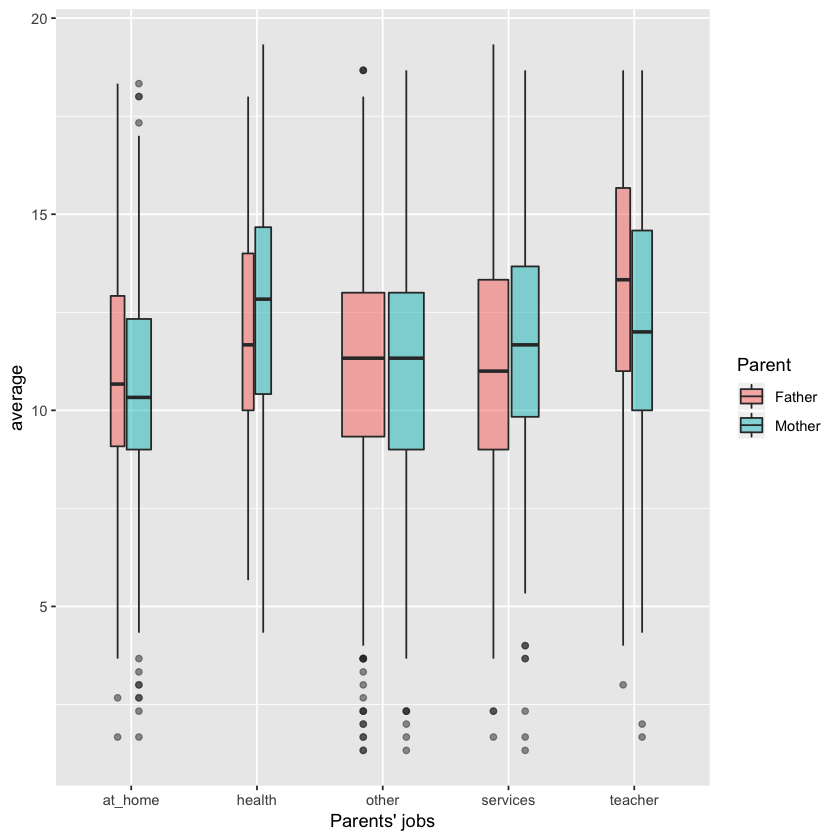

In [58]:
family %>%
    select(Mjob, Fjob, average)%>%
    gather(key=Parent, value=job, -average) %>%
    ggplot(aes(job, average, fill=Parent))+
    geom_boxplot(varwidth=T, alpha=0.5)+
    xlab("Parents' jobs")+
    scale_fill_discrete(labels=c("Father","Mother"))

In [59]:
kruskal.test(average~Mjob, family)
pairwise.wilcox.test(family$average, family$Mjob, p.adjust.method = "BH")


	Kruskal-Wallis rank sum test

data:  average by Mjob
Kruskal-Wallis chi-squared = 41.254, df = 4, p-value = 2.381e-08



	Pairwise comparisons using Wilcoxon rank sum test 

data:  family$average and family$Mjob 

         at_home health  other   services
health   1.2e-05 -       -       -       
other    0.02937 0.00027 -       -       
services 0.00017 0.03358 0.03871 -       
teacher  1.2e-05 0.50467 0.00107 0.16099 

P value adjustment method: BH 

#### The average scores differ according to the mother's jobs. Students whose mother is a **housemaker** tend to have lower score than all of their their counterparts, and those whose mother works in **health** industry tend to have higher scores than most of their counterparts.

In [60]:
kruskal.test(average~Fjob, family)
pairwise.wilcox.test(family$average, family$Fjob, p.adjust.method = "BH")


	Kruskal-Wallis rank sum test

data:  average by Fjob
Kruskal-Wallis chi-squared = 22.169, df = 4, p-value = 0.0001854



	Pairwise comparisons using Wilcoxon rank sum test 

data:  family$average and family$Fjob 

         at_home health  other   services
health   0.22982 -       -       -       
other    0.64958 0.22982 -       -       
services 0.68690 0.22982 0.79438 -       
teacher  0.00150 0.16550 0.00012 0.00016 

P value adjustment method: BH 

#### The average scores differ according to the father's jobs.Students whose father is a **teacher** tends to have higher average score than all others.

### **3. MOTHER'S AND FATHER'S EDUCATION**

We examine the effect of mother's and father's education on a student's performance by first looking into the boxplot for both of them

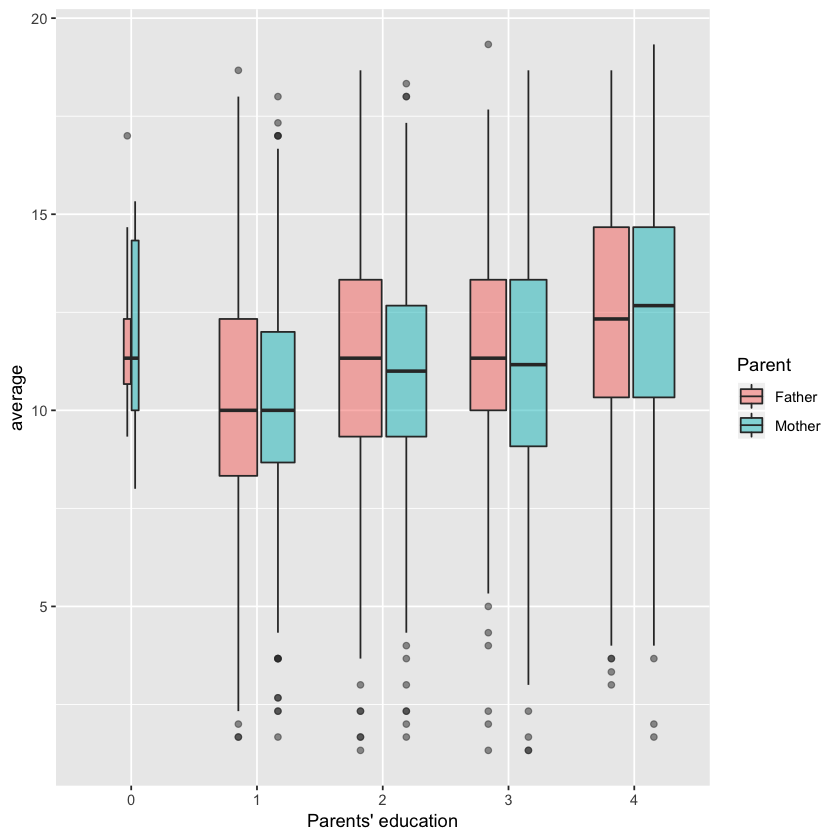

In [61]:
family %>%
    select(Medu, Fedu, average) %>%
    gather(key=Parent, value=education, -average) %>% 
    ggplot(aes(x= factor(education), y= average, fill=Parent))+
    geom_boxplot(varwidth=T, alpha=0.5)+
    xlab("Parents' education")+
    scale_fill_discrete(labels=c("Father","Mother"))

In [62]:
kruskal.test(average~Medu, family)
pairwise.wilcox.test(family$average, family$Medu, p.adjust.method = "BH")


	Kruskal-Wallis rank sum test

data:  average by Medu
Kruskal-Wallis chi-squared = 70.43, df = 4, p-value = 1.842e-14



	Pairwise comparisons using Wilcoxon rank sum test 

data:  family$average and family$Medu 

  0     1       2       3      
1 0.212 -       -       -      
2 0.683 0.002   -       -      
3 0.698 0.002   0.683   -      
4 0.536 2.6e-14 4.9e-08 2.2e-05

P value adjustment method: BH 

In [63]:
kruskal.test(average~Fedu, family)
pairwise.wilcox.test(family$average, family$Fedu, p.adjust.method = "BH")


	Kruskal-Wallis rank sum test

data:  average by Fedu
Kruskal-Wallis chi-squared = 48.589, df = 4, p-value = 7.112e-10



	Pairwise comparisons using Wilcoxon rank sum test 

data:  family$average and family$Fedu 

  0       1       2       3      
1 0.17823 -       -       -      
2 0.73826 0.00054 -       -      
3 0.79704 5.5e-05 0.61558 -      
4 0.61558 4.7e-10 0.00071 0.00666

P value adjustment method: BH 

#### Students whose parents' education is at **primary** level tend to have significantly lover average score than others, and students whose parents reach **higher** education have significantly higher average score.

### 4. FAMILY RELATIONSHIP

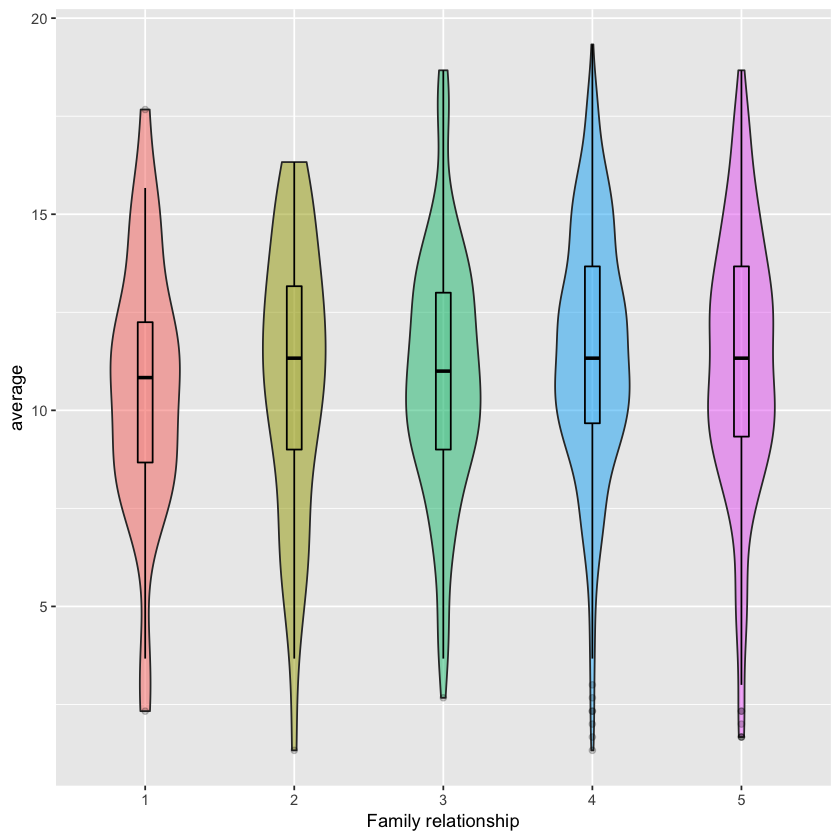

In [64]:
family %>%
    select(famrel,average) %>%
    ggplot(aes(x=factor(famrel),y=average, fill=factor(famrel)))+
    geom_violin(width=0.5, alpha=0.5)+
    geom_boxplot(width=0.1, color="black", alpha=0.2)+
    theme(legend.position="none")+
    xlab("Family relationship")

In [65]:
kruskal.test(average~famrel, family)


	Kruskal-Wallis rank sum test

data:  average by famrel
Kruskal-Wallis chi-squared = 6.7394, df = 4, p-value = 0.1503


P-value is large, indicating that family relationship doesn't imply much about a student's performance.

### Takeaways:
 
 - Parents' education and parents' jobs are main indicator of a student's overall performance. 
 - Between the two factor, education factor confirms an common presumption that children will benefit from parents with a degree in higher education. Meanwhile, the job factor reveals more interesting information that the students who have mother working in health industry and father working as teachers tend to perform better overall.